# Deep Dive: SQL Joins

A ground-up exploration of SQL joins — from manual loops to production queries — implemented in pure Python and SQLite.

**What you will learn:**
- Why joins exist and the problem they solve
- Cartesian products, inner joins, and all outer join variants
- Common pitfalls: duplicate rows and NULLs
- How join algorithms work under the hood (nested loop, hash, sort-merge)
- Real SQL joins with SQLite
- Advanced patterns: self-joins, anti-joins, cross joins

---
## Stage 0: The Problem — One Question, Two Tables

### Motivation
You have customer data in one table and order data in another. A simple question like "What did Alice buy?" requires combining them. Without joins, you'd write nested loops by hand.

### Intuition
Think of it like a phone book and a delivery log. The phone book has names and addresses; the delivery log has names and packages. To find "where was Alice's package delivered?", you need to match entries across both.

In [1]:
# Our two tables: customers and orders
customers = [
    {"customer_id": 1, "name": "Alice",   "city": "New York"},
    {"customer_id": 2, "name": "Bob",     "city": "Chicago"},
    {"customer_id": 3, "name": "Charlie", "city": "Boston"},
    {"customer_id": 4, "name": "Diana",   "city": "Seattle"},  # no orders
]

orders = [
    {"order_id": 101, "customer_id": 1, "product": "Laptop",    "amount": 999},
    {"order_id": 102, "customer_id": 2, "product": "Phone",     "amount": 699},
    {"order_id": 103, "customer_id": 1, "product": "Headphones","amount": 199},
    {"order_id": 104, "customer_id": 5, "product": "Tablet",    "amount": 499},  # no matching customer
]

print("Customers:")
for c in customers:
    print(f"  {c}")

print("\nOrders:")
for o in orders:
    print(f"  {o}")

Customers:
  {'customer_id': 1, 'name': 'Alice', 'city': 'New York'}
  {'customer_id': 2, 'name': 'Bob', 'city': 'Chicago'}
  {'customer_id': 3, 'name': 'Charlie', 'city': 'Boston'}
  {'customer_id': 4, 'name': 'Diana', 'city': 'Seattle'}

Orders:
  {'order_id': 101, 'customer_id': 1, 'product': 'Laptop', 'amount': 999}
  {'order_id': 102, 'customer_id': 2, 'product': 'Phone', 'amount': 699}
  {'order_id': 103, 'customer_id': 1, 'product': 'Headphones', 'amount': 199}
  {'order_id': 104, 'customer_id': 5, 'product': 'Tablet', 'amount': 499}


In [2]:
# The manual approach: nested loops to answer "What did each customer buy?"
print("Manual nested-loop join:")
print("-" * 60)
results = []
for c in customers:
    for o in orders:
        if c["customer_id"] == o["customer_id"]:
            row = {"name": c["name"], "city": c["city"],
                   "product": o["product"], "amount": o["amount"]}
            results.append(row)
            print(f"  {c['name']} from {c['city']} bought {o['product']} for ${o['amount']}")

print(f"\nMatched {len(results)} rows.")
print(f"Diana (customer_id=4) has no orders — she disappears.")
print(f"Order 104 (customer_id=5) has no customer — it disappears too.")

Manual nested-loop join:
------------------------------------------------------------
  Alice from New York bought Laptop for $999
  Alice from New York bought Headphones for $199
  Bob from Chicago bought Phone for $699

Matched 3 rows.
Diana (customer_id=4) has no orders — she disappears.
Order 104 (customer_id=5) has no customer — it disappears too.


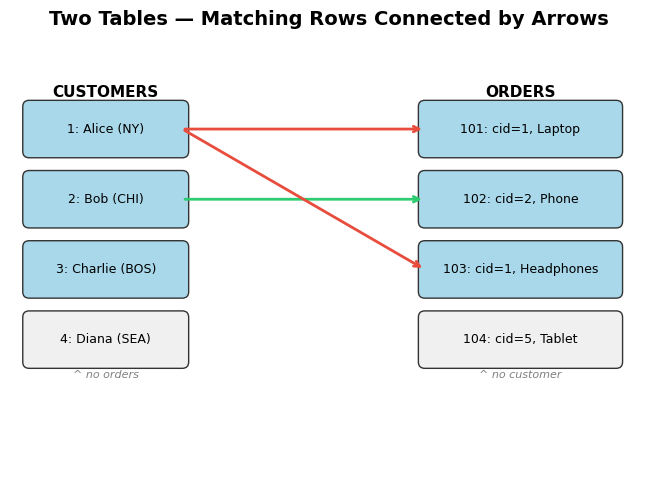

In [3]:
# Visualization: two tables with arrows connecting matching rows
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_xlim(0, 10)
ax.set_ylim(0, 7)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Two Tables — Matching Rows Connected by Arrows', fontsize=14, fontweight='bold')

# Draw customers table
cx, cy_start = 1.5, 5.5
ax.text(cx, cy_start + 0.5, 'CUSTOMERS', fontsize=11, fontweight='bold', ha='center')
cust_labels = ['1: Alice (NY)', '2: Bob (CHI)', '3: Charlie (BOS)', '4: Diana (SEA)']
cust_colors = ['#a8d8ea', '#a8d8ea', '#a8d8ea', '#f0f0f0']
cust_y = []
for i, (label, color) in enumerate(zip(cust_labels, cust_colors)):
    y = cy_start - i * 1.1
    cust_y.append(y)
    rect = mpatches.FancyBboxPatch((0.3, y - 0.35), 2.4, 0.7, boxstyle='round,pad=0.1',
                                    facecolor=color, edgecolor='#333')
    ax.add_patch(rect)
    ax.text(cx, y, label, ha='center', va='center', fontsize=9)

# Draw orders table
ox, oy_start = 8.0, 5.5
ax.text(ox, oy_start + 0.5, 'ORDERS', fontsize=11, fontweight='bold', ha='center')
ord_labels = ['101: cid=1, Laptop', '102: cid=2, Phone', '103: cid=1, Headphones', '104: cid=5, Tablet']
ord_colors = ['#a8d8ea', '#a8d8ea', '#a8d8ea', '#f0f0f0']
ord_y = []
for i, (label, color) in enumerate(zip(ord_labels, ord_colors)):
    y = oy_start - i * 1.1
    ord_y.append(y)
    rect = mpatches.FancyBboxPatch((6.5, y - 0.35), 3.0, 0.7, boxstyle='round,pad=0.1',
                                    facecolor=color, edgecolor='#333')
    ax.add_patch(rect)
    ax.text(ox, y, label, ha='center', va='center', fontsize=9)

# Draw arrows for matching rows
matches = [(0, 0), (1, 1), (0, 2)]  # customer index -> order index
arrow_colors = ['#e74c3c', '#2ecc71', '#e74c3c']
for (ci, oi), ac in zip(matches, arrow_colors):
    ax.annotate('', xy=(6.5, ord_y[oi]), xytext=(2.7, cust_y[ci]),
                arrowprops=dict(arrowstyle='->', color=ac, lw=2))

# Labels for unmatched
ax.text(cx, cust_y[3] - 0.6, '^ no orders', ha='center', fontsize=8, color='gray', style='italic')
ax.text(ox, ord_y[3] - 0.6, '^ no customer', ha='center', fontsize=8, color='gray', style='italic')

plt.tight_layout()
plt.show()

---
## Stage 1: The Cartesian Product — The Brute-Force Foundation

### Motivation
Before filtering, understand what "combining every row with every row" means. This is the mathematical foundation all joins build on.

### Intuition
Like seating arrangements — if you have 3 people and 4 chairs, there are 12 possible (person, chair) pairings. Most are nonsensical, but you start with all of them and then filter.

In [4]:
def cartesian_product(left, right):
    """Return every possible combination of rows from left and right."""
    result = []
    for l_row in left:
        for r_row in right:
            combined = {}
            # Prefix keys to avoid collisions
            for k, v in l_row.items():
                combined[f"l.{k}"] = v
            for k, v in r_row.items():
                combined[f"r.{k}"] = v
            result.append(combined)
    return result

# Use smaller tables for clarity
small_customers = customers[:3]  # Alice, Bob, Charlie
small_orders = orders[:3]        # 101, 102, 103

cp = cartesian_product(small_customers, small_orders)

print(f"Left table:  {len(small_customers)} rows")
print(f"Right table: {len(small_orders)} rows")
print(f"Cartesian product: {len(small_customers)} x {len(small_orders)} = {len(cp)} rows\n")

print(f"{'l.name':<10} {'l.cid':<6} {'r.oid':<6} {'r.cid':<6} {'r.product':<12} {'Match?':<6}")
print("-" * 50)
for row in cp:
    match = "YES" if row['l.customer_id'] == row['r.customer_id'] else "--"
    print(f"{row['l.name']:<10} {row['l.customer_id']:<6} {row['r.order_id']:<6} "
          f"{row['r.customer_id']:<6} {row['r.product']:<12} {match:<6}")

matches = sum(1 for r in cp if r['l.customer_id'] == r['r.customer_id'])
print(f"\nOnly {matches} out of {len(cp)} rows are meaningful matches.")
print(f"That's {100 * (len(cp) - matches) / len(cp):.0f}% waste — this is why we filter!")

Left table:  3 rows
Right table: 3 rows
Cartesian product: 3 x 3 = 9 rows

l.name     l.cid  r.oid  r.cid  r.product    Match?
--------------------------------------------------
Alice      1      101    1      Laptop       YES   
Alice      1      102    2      Phone        --    
Alice      1      103    1      Headphones   YES   
Bob        2      101    1      Laptop       --    
Bob        2      102    2      Phone        YES   
Bob        2      103    1      Headphones   --    
Charlie    3      101    1      Laptop       --    
Charlie    3      102    2      Phone        --    
Charlie    3      103    1      Headphones   --    

Only 3 out of 9 rows are meaningful matches.
That's 67% waste — this is why we filter!


---
## Stage 2: Inner Join — Keep Only the Matches

### Motivation
The cartesian product gives us everything; inner join filters to only matching rows. This is the most common join.

### Intuition
Like a Venn diagram overlap — only rows that exist in BOTH tables survive.

In [5]:
def inner_join(left, right, left_key, right_key):
    """Inner join: keep only rows where left_key == right_key."""
    result = []
    for l_row in left:
        for r_row in right:
            if l_row[left_key] == r_row[right_key]:
                combined = {**l_row}
                for k, v in r_row.items():
                    if k != right_key:  # avoid duplicate key column
                        combined[k] = v
                result.append(combined)
    return result

ij = inner_join(customers, orders, "customer_id", "customer_id")

print("Inner Join Result:")
print(f"{'name':<10} {'city':<10} {'order_id':<10} {'product':<12} {'amount':<8}")
print("-" * 52)
for row in ij:
    print(f"{row['name']:<10} {row['city']:<10} {row['order_id']:<10} {row['product']:<12} ${row['amount']:<7}")

print(f"\n{len(ij)} rows returned.")

# Who disappeared?
joined_ids = {r['customer_id'] for r in ij}
all_cust_ids = {c['customer_id'] for c in customers}
missing = all_cust_ids - joined_ids
print(f"Customers with no match (dropped): customer_id(s) {missing}")
print("Diana (id=4) had no orders — inner join drops her silently.")

Inner Join Result:
name       city       order_id   product      amount  
----------------------------------------------------
Alice      New York   101        Laptop       $999    
Alice      New York   103        Headphones   $199    
Bob        Chicago    102        Phone        $699    

3 rows returned.
Customers with no match (dropped): customer_id(s) {3, 4}
Diana (id=4) had no orders — inner join drops her silently.


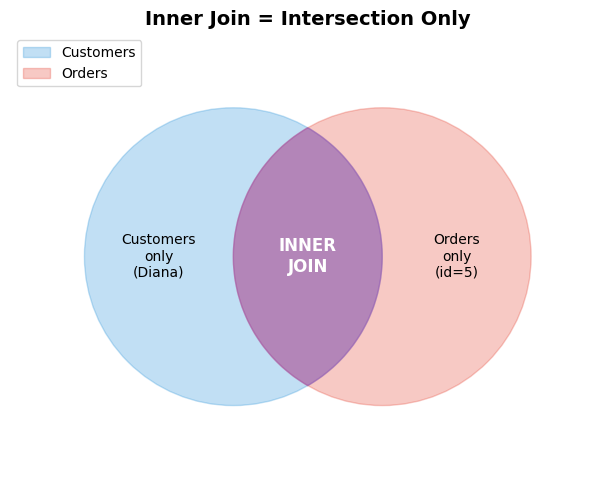

In [6]:
# Visualization: Venn diagram showing inner join
fig, ax = plt.subplots(figsize=(7, 5))

# Draw two overlapping circles
left_circle = plt.Circle((3, 3), 2, color='#3498db', alpha=0.3, label='Customers')
right_circle = plt.Circle((5, 3), 2, color='#e74c3c', alpha=0.3, label='Orders')
ax.add_patch(left_circle)
ax.add_patch(right_circle)

# Highlight the intersection
from matplotlib.patches import Arc
from matplotlib.collections import PatchCollection
import numpy as np

theta = np.linspace(0, 2 * np.pi, 300)
lx = 3 + 2 * np.cos(theta)
ly = 3 + 2 * np.sin(theta)
rx = 5 + 2 * np.cos(theta)
ry = 3 + 2 * np.sin(theta)

# Fill intersection region
# We'll use a simple approach: fill between the two arcs
t = np.linspace(-np.pi/3, np.pi/3, 100)
# Right arc of left circle
arc1_x = 3 + 2 * np.cos(t)
arc1_y = 3 + 2 * np.sin(t)
# Left arc of right circle
t2 = np.linspace(2*np.pi/3, 4*np.pi/3, 100)
arc2_x = 5 + 2 * np.cos(t2)
arc2_y = 3 + 2 * np.sin(t2)

fill_x = np.concatenate([arc1_x, arc2_x])
fill_y = np.concatenate([arc1_y, arc2_y])
ax.fill(fill_x, fill_y, color='#9b59b6', alpha=0.5)

# Labels
ax.text(2, 3, 'Customers\nonly\n(Diana)', ha='center', va='center', fontsize=10)
ax.text(4, 3, 'INNER\nJOIN', ha='center', va='center', fontsize=12, fontweight='bold', color='white')
ax.text(6, 3, 'Orders\nonly\n(id=5)', ha='center', va='center', fontsize=10)

ax.set_xlim(0, 8)
ax.set_ylim(0, 6)
ax.set_aspect('equal')
ax.legend(loc='upper left', fontsize=10)
ax.set_title('Inner Join = Intersection Only', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

---
## Stage 3: Left, Right, and Full Outer Joins — Handling the Missing

### Motivation
Inner join drops customers who never ordered. Sometimes you NEED those — "show me ALL customers, even ones who never bought anything."

### Intuition
Left join = "keep everyone from the left table, fill in NULLs for missing matches." Like taking attendance — everyone on the roster appears, even if they were absent.

In [7]:
def left_join(left, right, left_key, right_key):
    """Left join: keep ALL left rows. Fill None for non-matching right columns."""
    # Collect right-side column names (excluding the join key)
    r_cols = [k for k in right[0].keys() if k != right_key] if right else []
    result = []
    for l_row in left:
        matched = False
        for r_row in right:
            if l_row[left_key] == r_row[right_key]:
                combined = {**l_row}
                for k in r_cols:
                    combined[k] = r_row[k]
                result.append(combined)
                matched = True
        if not matched:
            combined = {**l_row}
            for k in r_cols:
                combined[k] = None
            result.append(combined)
    return result


def right_join(left, right, left_key, right_key):
    """Right join: keep ALL right rows. Fill None for non-matching left columns."""
    # Swap and do a left join, then reorder columns
    l_cols = [k for k in left[0].keys() if k != left_key] if left else []
    result = []
    for r_row in right:
        matched = False
        for l_row in left:
            if l_row[left_key] == r_row[right_key]:
                combined = {**l_row}
                for k, v in r_row.items():
                    if k != right_key:
                        combined[k] = v
                result.append(combined)
                matched = True
        if not matched:
            combined = {left_key: r_row[right_key]}
            for k in l_cols:
                combined[k] = None
            for k, v in r_row.items():
                if k != right_key:
                    combined[k] = v
            result.append(combined)
    return result


def full_outer_join(left, right, left_key, right_key):
    """Full outer join: keep ALL rows from both sides."""
    r_cols = [k for k in right[0].keys() if k != right_key] if right else []
    l_cols = [k for k in left[0].keys() if k != left_key] if left else []
    result = []
    matched_right_indices = set()
    
    # Left join part
    for l_row in left:
        matched = False
        for ri, r_row in enumerate(right):
            if l_row[left_key] == r_row[right_key]:
                combined = {**l_row}
                for k in r_cols:
                    combined[k] = r_row[k]
                result.append(combined)
                matched_right_indices.add(ri)
                matched = True
        if not matched:
            combined = {**l_row}
            for k in r_cols:
                combined[k] = None
            result.append(combined)
    
    # Add unmatched right rows
    for ri, r_row in enumerate(right):
        if ri not in matched_right_indices:
            combined = {left_key: r_row[right_key]}
            for k in l_cols:
                combined[k] = None
            for k in r_cols:
                combined[k] = r_row[k]
            result.append(combined)
    
    return result

print("Functions defined: left_join, right_join, full_outer_join")

Functions defined: left_join, right_join, full_outer_join


In [8]:
def print_join_result(rows, title):
    """Pretty-print join results."""
    print(f"\n{'=' * 65}")
    print(f"  {title}")
    print(f"{'=' * 65}")
    if not rows:
        print("  (empty)")
        return
    # Determine columns to display
    display_cols = ['customer_id', 'name', 'city', 'order_id', 'product', 'amount']
    cols = [c for c in display_cols if c in rows[0]]
    
    header = "".join(f"{c:<13}" for c in cols)
    print(f"  {header}")
    print(f"  {'-' * (13 * len(cols))}")
    for row in rows:
        vals = []
        for c in cols:
            v = row.get(c)
            vals.append(f"{str(v) if v is not None else 'NULL':<13}")
        print(f"  {''.join(vals)}")
    print(f"  ({len(rows)} rows)")


# Run all four join types
ij  = inner_join(customers, orders, "customer_id", "customer_id")
lj  = left_join(customers, orders, "customer_id", "customer_id")
rj  = right_join(customers, orders, "customer_id", "customer_id")
foj = full_outer_join(customers, orders, "customer_id", "customer_id")

print_join_result(ij,  "INNER JOIN")
print_join_result(lj,  "LEFT JOIN (all customers kept)")
print_join_result(rj,  "RIGHT JOIN (all orders kept)")
print_join_result(foj, "FULL OUTER JOIN (everything kept)")


  INNER JOIN
  customer_id  name         city         order_id     product      amount       
  ------------------------------------------------------------------------------
  1            Alice        New York     101          Laptop       999          
  1            Alice        New York     103          Headphones   199          
  2            Bob          Chicago      102          Phone        699          
  (3 rows)

  LEFT JOIN (all customers kept)
  customer_id  name         city         order_id     product      amount       
  ------------------------------------------------------------------------------
  1            Alice        New York     101          Laptop       999          
  1            Alice        New York     103          Headphones   199          
  2            Bob          Chicago      102          Phone        699          
  3            Charlie      Boston       NULL         NULL         NULL         
  4            Diana        Seattle      NULL     

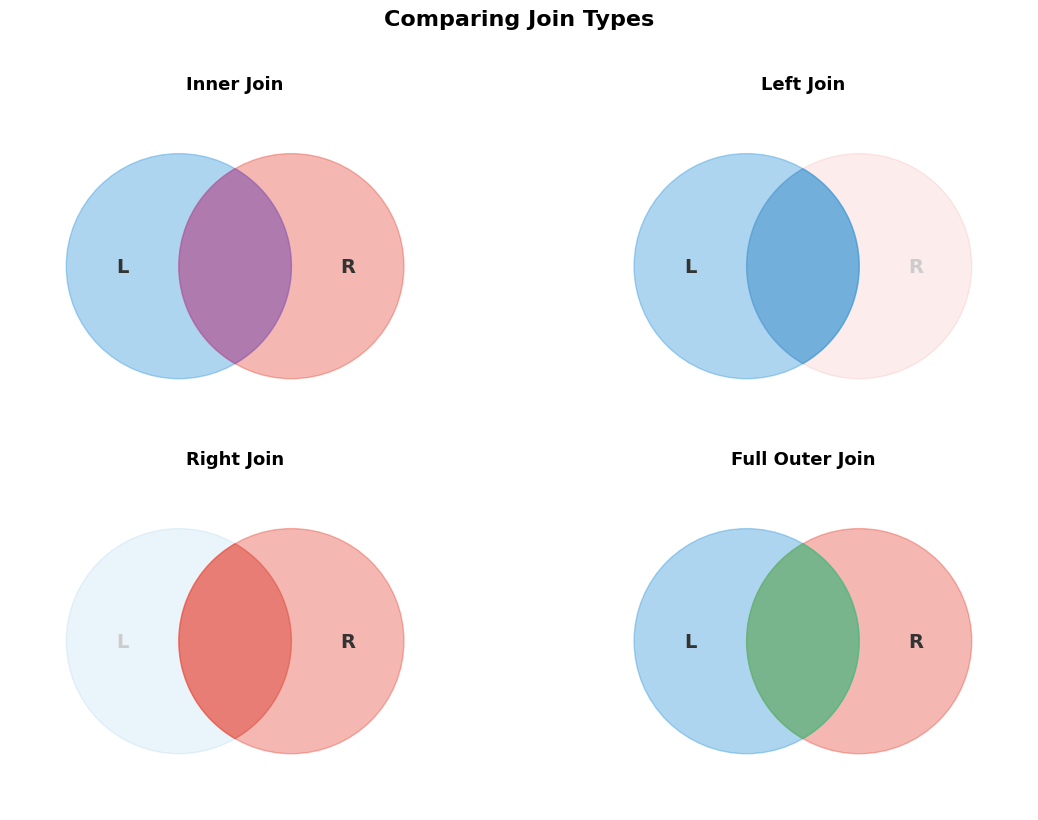

In [9]:
# Visualization: side-by-side comparison of all four join types
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Comparing Join Types', fontsize=16, fontweight='bold', y=1.02)

join_configs = [
    ('Inner Join', '#9b59b6', True, True),    # highlight intersection
    ('Left Join', '#3498db', True, False),      # highlight left + intersection
    ('Right Join', '#e74c3c', False, True),     # highlight right + intersection
    ('Full Outer Join', '#2ecc71', True, True),  # highlight everything
]

for ax, (title, color, keep_left, keep_right) in zip(axes.flat, join_configs):
    # Draw circles
    left_alpha = 0.4 if keep_left else 0.1
    right_alpha = 0.4 if keep_right else 0.1
    
    lc = plt.Circle((3, 3), 2, color='#3498db', alpha=left_alpha)
    rc = plt.Circle((5, 3), 2, color='#e74c3c', alpha=right_alpha)
    ax.add_patch(lc)
    ax.add_patch(rc)
    
    # Always highlight intersection
    t = np.linspace(-np.pi/3, np.pi/3, 100)
    arc1_x = 3 + 2 * np.cos(t)
    arc1_y = 3 + 2 * np.sin(t)
    t2 = np.linspace(2*np.pi/3, 4*np.pi/3, 100)
    arc2_x = 5 + 2 * np.cos(t2)
    arc2_y = 3 + 2 * np.sin(t2)
    fill_x = np.concatenate([arc1_x, arc2_x])
    fill_y = np.concatenate([arc1_y, arc2_y])
    ax.fill(fill_x, fill_y, color=color, alpha=0.5)
    
    ax.text(2, 3, 'L', ha='center', va='center', fontsize=14, fontweight='bold',
            color='#333' if keep_left else '#ccc')
    ax.text(6, 3, 'R', ha='center', va='center', fontsize=14, fontweight='bold',
            color='#333' if keep_right else '#ccc')
    
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 6)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

---
## Stage 4: What Goes Wrong — The Duplicate Trap

### Motivation
The #1 join mistake — when the join key isn't unique, you get row multiplication. A customer with 3 orders joins to produce 3 rows, which can silently inflate aggregations.

### Intuition
Think of it like a many-to-many dance card. If Alice has 3 orders and 2 addresses, you get 6 rows — not 3, not 2.

In [10]:
# Scenario: a customer has multiple addresses AND multiple orders
addresses = [
    {"customer_id": 1, "address": "123 Main St"},
    {"customer_id": 1, "address": "456 Oak Ave"},   # Alice has TWO addresses
    {"customer_id": 2, "address": "789 Pine Rd"},
]

orders_dup = [
    {"customer_id": 1, "product": "Laptop",     "amount": 999},
    {"customer_id": 1, "product": "Headphones", "amount": 199},
    {"customer_id": 1, "product": "Mouse",      "amount": 49},   # Alice has THREE orders
    {"customer_id": 2, "product": "Phone",      "amount": 699},
]

# Join addresses x orders on customer_id (MANY-TO-MANY!)
bad_join = inner_join(addresses, orders_dup, "customer_id", "customer_id")

print("Joining addresses (2 for Alice) x orders (3 for Alice):")
print(f"Expected Alice rows: 2 addresses x 3 orders = 6")
print(f"{'address':<18} {'product':<12} {'amount':<8}")
print("-" * 40)
alice_count = 0
for row in bad_join:
    if row['customer_id'] == 1:
        alice_count += 1
        print(f"{row['address']:<18} {row['product']:<12} ${row['amount']:<7}")
print(f"\nAlice appears in {alice_count} rows (2 x 3 = 6).")

Joining addresses (2 for Alice) x orders (3 for Alice):
Expected Alice rows: 2 addresses x 3 orders = 6
address            product      amount  
----------------------------------------
123 Main St        Laptop       $999    
123 Main St        Headphones   $199    
123 Main St        Mouse        $49     
456 Oak Ave        Laptop       $999    
456 Oak Ave        Headphones   $199    
456 Oak Ave        Mouse        $49     

Alice appears in 6 rows (2 x 3 = 6).


In [11]:
# The WRONG total: summing amounts over the bad join
wrong_total_alice = sum(r['amount'] for r in bad_join if r['customer_id'] == 1)
correct_total_alice = sum(r['amount'] for r in orders_dup if r['customer_id'] == 1)

print("THE DUPLICATE TRAP:")
print(f"  Alice's actual order total:  ${correct_total_alice}")
print(f"  SUM from bad join:           ${wrong_total_alice}")
print(f"  Inflation factor:            {wrong_total_alice / correct_total_alice:.0f}x (= number of addresses)")
print()
print("FIX: Deduplicate before joining, or aggregate BEFORE the join.")
print()

# The fix: aggregate orders first, THEN join
from collections import defaultdict
order_totals = defaultdict(float)
for o in orders_dup:
    order_totals[o['customer_id']] += o['amount']

agg_orders = [{"customer_id": k, "total_spent": v} for k, v in order_totals.items()]
fixed_join = inner_join(addresses, agg_orders, "customer_id", "customer_id")

print("FIXED: aggregate first, then join:")
for row in fixed_join:
    if row['customer_id'] == 1:
        print(f"  {row['address']:<18} total_spent=${row['total_spent']}")

# Verify
assert wrong_total_alice == correct_total_alice * 2, "Inflation factor should be 2 (number of addresses)"
print("\nAssertion passed: wrong total is exactly 2x the correct total.")

THE DUPLICATE TRAP:
  Alice's actual order total:  $1247
  SUM from bad join:           $2494
  Inflation factor:            2x (= number of addresses)

FIX: Deduplicate before joining, or aggregate BEFORE the join.

FIXED: aggregate first, then join:
  123 Main St        total_spent=$1247.0
  456 Oak Ave        total_spent=$1247.0

Assertion passed: wrong total is exactly 2x the correct total.


---
## Stage 5: NULL — The Silent Join Killer

### Motivation
NULL never equals NULL. Joining on columns with NULLs silently drops rows that most people expect to match.

In [12]:
# Demonstrate: NULL != NULL in join semantics
left_table = [
    {"id": 1, "group": "A"},
    {"id": 2, "group": None},   # NULL group
    {"id": 3, "group": "B"},
]

right_table = [
    {"group": "A", "label": "Alpha"},
    {"group": None, "label": "Unknown"},  # NULL group
    {"group": "B", "label": "Beta"},
]

# Standard inner join — NULL == NULL is False!
result = inner_join(left_table, right_table, "group", "group")

print("Left table:")
for r in left_table:
    print(f"  id={r['id']}, group={r['group']}")

print("\nRight table:")
for r in right_table:
    print(f"  group={r['group']}, label={r['label']}")

print(f"\nInner join result ({len(result)} rows):")
for r in result:
    print(f"  id={r['id']}, group={r['group']}, label={r['label']}")

print(f"\nRow with id=2 (group=None) is DROPPED because None == None is {None == None} in Python,")
print("but in SQL, NULL = NULL evaluates to NULL (falsy). Our join function")
print("uses Python == which returns True, but SQL engines would drop it.")
print("\nLet's fix our join to match SQL semantics:")

Left table:
  id=1, group=A
  id=2, group=None
  id=3, group=B

Right table:
  group=A, label=Alpha
  group=None, label=Unknown
  group=B, label=Beta

Inner join result (3 rows):
  id=1, group=A, label=Alpha
  id=2, group=None, label=Unknown
  id=3, group=B, label=Beta

Row with id=2 (group=None) is DROPPED because None == None is True in Python,
but in SQL, NULL = NULL evaluates to NULL (falsy). Our join function
uses Python == which returns True, but SQL engines would drop it.

Let's fix our join to match SQL semantics:


In [13]:
def inner_join_sql_nulls(left, right, left_key, right_key):
    """Inner join with SQL NULL semantics: NULL never equals anything, not even NULL."""
    result = []
    for l_row in left:
        for r_row in right:
            lval = l_row[left_key]
            rval = r_row[right_key]
            # SQL semantics: NULL = anything is FALSE
            if lval is not None and rval is not None and lval == rval:
                combined = {**l_row}
                for k, v in r_row.items():
                    if k != right_key:
                        combined[k] = v
                result.append(combined)
    return result

result_sql = inner_join_sql_nulls(left_table, right_table, "group", "group")

print(f"SQL-style inner join result ({len(result_sql)} rows):")
for r in result_sql:
    print(f"  id={r['id']}, group={r['group']}, label={r['label']}")

print(f"\nid=2 with group=NULL is now properly dropped.")

# COALESCE workaround
def coalesce(value, default):
    """SQL COALESCE: return value if not None, else default."""
    return value if value is not None else default

# Apply COALESCE before joining
left_fixed = [{**r, "group": coalesce(r["group"], "__MISSING__")} for r in left_table]
right_fixed = [{**r, "group": coalesce(r["group"], "__MISSING__")} for r in right_table]

result_fixed = inner_join(left_fixed, right_fixed, "group", "group")
print(f"\nWith COALESCE workaround ({len(result_fixed)} rows):")
for r in result_fixed:
    print(f"  id={r['id']}, group={r['group']}, label={r['label']}")
print("\nNow the NULL rows match via the sentinel value.")

SQL-style inner join result (2 rows):
  id=1, group=A, label=Alpha
  id=3, group=B, label=Beta

id=2 with group=NULL is now properly dropped.

With COALESCE workaround (3 rows):
  id=1, group=A, label=Alpha
  id=2, group=__MISSING__, label=Unknown
  id=3, group=B, label=Beta

Now the NULL rows match via the sentinel value.


---
## Stage 6: Join Algorithms — How the Engine Does It

### Motivation
Now that we understand WHAT joins do, understand HOW they're computed efficiently. Three strategies: nested loop, hash join, sort-merge join.

### Intuition
- **Nested loop** = checking every combination (O(n*m)).
- **Hash join** = build a lookup table first (O(n+m)).
- **Sort-merge** = sort both sides, then walk through together (O(n log n + m log m)).

In [14]:
def nested_loop_join(left, right, left_key, right_key):
    """O(n * m) — check every pair."""
    result = []
    for l_row in left:
        for r_row in right:
            if l_row[left_key] == r_row[right_key]:
                result.append({**l_row, **{k: v for k, v in r_row.items() if k != right_key}})
    return result


def hash_join(left, right, left_key, right_key):
    """O(n + m) — build hash table on left, probe with right."""
    # Build phase: index left table by key
    hash_table = defaultdict(list)
    for l_row in left:
        hash_table[l_row[left_key]].append(l_row)
    
    # Probe phase: look up each right row
    result = []
    for r_row in right:
        key = r_row[right_key]
        if key in hash_table:
            for l_row in hash_table[key]:
                result.append({**l_row, **{k: v for k, v in r_row.items() if k != right_key}})
    return result


def sort_merge_join(left, right, left_key, right_key):
    """O(n log n + m log m) — sort both, then merge."""
    left_sorted = sorted(left, key=lambda r: r[left_key])
    right_sorted = sorted(right, key=lambda r: r[right_key])
    
    result = []
    i, j = 0, 0
    while i < len(left_sorted) and j < len(right_sorted):
        lk = left_sorted[i][left_key]
        rk = right_sorted[j][right_key]
        
        if lk == rk:
            # Find all matching rows on both sides
            # Collect all left rows with this key
            left_group = []
            ii = i
            while ii < len(left_sorted) and left_sorted[ii][left_key] == lk:
                left_group.append(left_sorted[ii])
                ii += 1
            # Collect all right rows with this key
            right_group = []
            jj = j
            while jj < len(right_sorted) and right_sorted[jj][right_key] == rk:
                right_group.append(right_sorted[jj])
                jj += 1
            # Cross-join the groups
            for lr in left_group:
                for rr in right_group:
                    result.append({**lr, **{k: v for k, v in rr.items() if k != right_key}})
            i, j = ii, jj
        elif lk < rk:
            i += 1
        else:
            j += 1
    
    return result


# Verify all three produce the same result
r1 = nested_loop_join(customers, orders, "customer_id", "customer_id")
r2 = hash_join(customers, orders, "customer_id", "customer_id")
r3 = sort_merge_join(customers, orders, "customer_id", "customer_id")

# Sort results for comparison (since order may differ)
def sort_rows(rows):
    return sorted(rows, key=lambda r: (r.get('customer_id', 0), r.get('order_id', 0)))

r1s, r2s, r3s = sort_rows(r1), sort_rows(r2), sort_rows(r3)

assert r1s == r2s, "Hash join results differ from nested loop!"
assert r1s == r3s, "Sort-merge join results differ from nested loop!"

print("All three algorithms produce identical results:")
for row in r1s:
    print(f"  cid={row['customer_id']}, {row['name']}, {row['product']}")
print(f"\nAssertion passed: nested_loop == hash_join == sort_merge_join")

All three algorithms produce identical results:
  cid=1, Alice, Laptop
  cid=1, Alice, Headphones
  cid=2, Bob, Phone

Assertion passed: nested_loop == hash_join == sort_merge_join


---
## Stage 7: Performance Showdown — Benchmarking Join Algorithms

### Motivation
Theory says hash join wins for equi-joins. Let's prove it empirically.

In [15]:
import time
import random

def generate_tables(n_left, n_right, n_keys):
    """Generate random left and right tables with n_keys distinct join keys."""
    left = [{"id": i, "key": random.randint(1, n_keys), "lval": random.random()}
            for i in range(n_left)]
    right = [{"id": i, "key": random.randint(1, n_keys), "rval": random.random()}
             for i in range(n_right)]
    return left, right


def benchmark_join(join_fn, left, right, n_runs=3):
    """Benchmark a join function, return average time in seconds."""
    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        join_fn(left, right, "key", "key")
        elapsed = time.perf_counter() - start
        times.append(elapsed)
    return sum(times) / len(times)


sizes = [500, 1000, 2000, 4000]
algorithms = [
    ("Nested Loop", nested_loop_join),
    ("Hash Join", hash_join),
    ("Sort-Merge", sort_merge_join),
]

results = {name: [] for name, _ in algorithms}

random.seed(42)
for size in sizes:
    left, right = generate_tables(size, size, size // 5)
    print(f"\nBenchmarking with {size} rows per table:")
    for name, fn in algorithms:
        avg_time = benchmark_join(fn, left, right)
        results[name].append(avg_time)
        print(f"  {name:<15}: {avg_time:.4f}s")

print("\nBenchmarking complete.")


Benchmarking with 500 rows per table:
  Nested Loop    : 0.0098s
  Hash Join      : 0.0012s
  Sort-Merge     : 0.0011s

Benchmarking with 1000 rows per table:
  Nested Loop    : 0.0407s
  Hash Join      : 0.0018s
  Sort-Merge     : 0.0020s

Benchmarking with 2000 rows per table:
  Nested Loop    : 0.1202s
  Hash Join      : 0.0036s
  Sort-Merge     : 0.0042s

Benchmarking with 4000 rows per table:
  Nested Loop    : 0.5615s
  Hash Join      : 0.0079s
  Sort-Merge     : 0.0086s

Benchmarking complete.


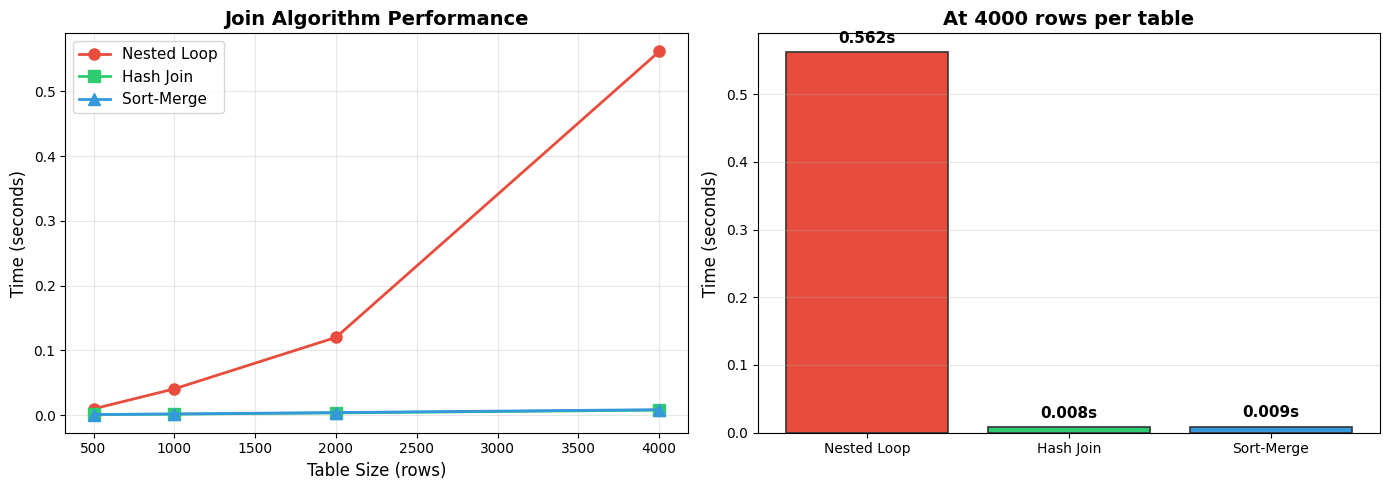


At 4000 rows: Hash Join is 71.1x faster than Nested Loop
At 4000 rows: Sort-Merge is 65.1x faster than Nested Loop


In [16]:
# Visualization: benchmark comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = {'Nested Loop': '#e74c3c', 'Hash Join': '#2ecc71', 'Sort-Merge': '#3498db'}
markers = {'Nested Loop': 'o', 'Hash Join': 's', 'Sort-Merge': '^'}

# Line plot
for name in results:
    ax1.plot(sizes, results[name], marker=markers[name], label=name,
             color=colors[name], linewidth=2, markersize=8)

ax1.set_xlabel('Table Size (rows)', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.set_title('Join Algorithm Performance', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bar chart for the largest size
bar_names = list(results.keys())
bar_times = [results[n][-1] for n in bar_names]
bar_colors = [colors[n] for n in bar_names]
bars = ax2.bar(bar_names, bar_times, color=bar_colors, edgecolor='#333', linewidth=1.2)
for bar, t in zip(bars, bar_times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{t:.3f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('Time (seconds)', fontsize=12)
ax2.set_title(f'At {sizes[-1]} rows per table', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print speedup
nl_time = results['Nested Loop'][-1]
hj_time = results['Hash Join'][-1]
sm_time = results['Sort-Merge'][-1]
print(f"\nAt {sizes[-1]} rows: Hash Join is {nl_time/hj_time:.1f}x faster than Nested Loop")
print(f"At {sizes[-1]} rows: Sort-Merge is {nl_time/sm_time:.1f}x faster than Nested Loop")

---
## Stage 8: Production Joins with SQLite — The Real Thing

### Motivation
In practice, you don't implement join algorithms — databases do it for you. Let's use SQLite to see real SQL joins.

In [17]:
import sqlite3

# Create in-memory database
conn = sqlite3.connect(":memory:")
cur = conn.cursor()

# Create tables
cur.execute("""
    CREATE TABLE customers (
        customer_id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        city TEXT NOT NULL
    )
""")

cur.execute("""
    CREATE TABLE orders (
        order_id INTEGER PRIMARY KEY,
        customer_id INTEGER,
        product TEXT NOT NULL,
        amount INTEGER NOT NULL
    )
""")

# Insert data (same as our Python lists)
cur.executemany("INSERT INTO customers VALUES (?, ?, ?)",
    [(1, 'Alice', 'New York'), (2, 'Bob', 'Chicago'),
     (3, 'Charlie', 'Boston'), (4, 'Diana', 'Seattle')])

cur.executemany("INSERT INTO orders VALUES (?, ?, ?, ?)",
    [(101, 1, 'Laptop', 999), (102, 2, 'Phone', 699),
     (103, 1, 'Headphones', 199), (104, 5, 'Tablet', 499)])

conn.commit()

def run_query(sql, title):
    """Execute SQL and pretty-print results."""
    cur.execute(sql)
    cols = [desc[0] for desc in cur.description]
    rows = cur.fetchall()
    print(f"\n{'=' * 65}")
    print(f"  {title}")
    print(f"  SQL: {sql.strip()[:80]}")
    print(f"{'=' * 65}")
    header = "".join(f"{c:<15}" for c in cols)
    print(f"  {header}")
    print(f"  {'-' * (15 * len(cols))}")
    for row in rows:
        vals = "".join(f"{str(v) if v is not None else 'NULL':<15}" for v in row)
        print(f"  {vals}")
    print(f"  ({len(rows)} rows)")
    return rows

print("SQLite database created with customers and orders tables.")

SQLite database created with customers and orders tables.


In [18]:
# INNER JOIN
inner_rows = run_query("""
    SELECT c.customer_id, c.name, c.city, o.order_id, o.product, o.amount
    FROM customers c
    INNER JOIN orders o ON c.customer_id = o.customer_id
    ORDER BY c.customer_id, o.order_id
""", "INNER JOIN")

# LEFT JOIN
left_rows = run_query("""
    SELECT c.customer_id, c.name, c.city, o.order_id, o.product, o.amount
    FROM customers c
    LEFT JOIN orders o ON c.customer_id = o.customer_id
    ORDER BY c.customer_id, o.order_id
""", "LEFT JOIN")

# RIGHT JOIN (simulated: SQLite < 3.39 doesn't support RIGHT JOIN, use swapped LEFT JOIN)
right_rows = run_query("""
    SELECT c.customer_id, c.name, c.city, o.order_id, o.product, o.amount
    FROM orders o
    LEFT JOIN customers c ON c.customer_id = o.customer_id
    ORDER BY o.order_id
""", "RIGHT JOIN (via swapped LEFT JOIN)")

# FULL OUTER JOIN (simulated with UNION)
full_rows = run_query("""
    SELECT c.customer_id, c.name, c.city, o.order_id, o.product, o.amount
    FROM customers c
    LEFT JOIN orders o ON c.customer_id = o.customer_id
    
    UNION
    
    SELECT o.customer_id, c.name, c.city, o.order_id, o.product, o.amount
    FROM orders o
    LEFT JOIN customers c ON c.customer_id = o.customer_id
""", "FULL OUTER JOIN (via UNION)")


  INNER JOIN
  SQL: SELECT c.customer_id, c.name, c.city, o.order_id, o.product, o.amount
    FROM c
  customer_id    name           city           order_id       product        amount         
  ------------------------------------------------------------------------------------------
  1              Alice          New York       101            Laptop         999            
  1              Alice          New York       103            Headphones     199            
  2              Bob            Chicago        102            Phone          699            
  (3 rows)

  LEFT JOIN
  SQL: SELECT c.customer_id, c.name, c.city, o.order_id, o.product, o.amount
    FROM c
  customer_id    name           city           order_id       product        amount         
  ------------------------------------------------------------------------------------------
  1              Alice          New York       101            Laptop         999            
  1              Alice          New York  

In [19]:
# Verify SQLite results match our Python implementations
# Compare inner join
py_inner = inner_join(customers, orders, "customer_id", "customer_id")
py_inner_tuples = set()
for r in py_inner:
    py_inner_tuples.add((r['customer_id'], r['name'], r['city'], r['order_id'], r['product'], r['amount']))

sql_inner_tuples = set(inner_rows)

assert py_inner_tuples == sql_inner_tuples, f"Mismatch!\nPython: {py_inner_tuples}\nSQL: {sql_inner_tuples}"
print("VERIFIED: Python inner_join matches SQLite INNER JOIN")

# Compare left join
py_left = left_join(customers, orders, "customer_id", "customer_id")
py_left_tuples = set()
for r in py_left:
    py_left_tuples.add((r['customer_id'], r['name'], r['city'], r.get('order_id'), r.get('product'), r.get('amount')))

sql_left_tuples = set(left_rows)

assert py_left_tuples == sql_left_tuples, f"Mismatch!\nPython: {py_left_tuples}\nSQL: {sql_left_tuples}"
print("VERIFIED: Python left_join matches SQLite LEFT JOIN")

print("\nAll SQL results match our Python implementations.")

VERIFIED: Python inner_join matches SQLite INNER JOIN
VERIFIED: Python left_join matches SQLite LEFT JOIN

All SQL results match our Python implementations.


---
## Stage 9: Advanced Patterns — Self-Joins, Anti-Joins, Cross Joins

### Motivation
Beyond the basics, joins enable powerful patterns: finding hierarchies (self-join), finding "NOT IN" efficiently (anti-join), generating combinations (cross join).

In [20]:
# --- SELF-JOIN: Employee-Manager Hierarchy ---
cur.execute("DROP TABLE IF EXISTS employees")
cur.execute("""
    CREATE TABLE employees (
        emp_id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        manager_id INTEGER
    )
""")
cur.executemany("INSERT INTO employees VALUES (?, ?, ?)",
    [(1, 'Eve', None),      # CEO, no manager
     (2, 'Frank', 1),       # reports to Eve
     (3, 'Grace', 1),       # reports to Eve
     (4, 'Hank', 2),        # reports to Frank
     (5, 'Ivy', 2)]         # reports to Frank
)
conn.commit()

print("SELF-JOIN: Who reports to whom?")
print("(Join employees table with itself)\n")

run_query("""
    SELECT e.name AS employee, m.name AS manager
    FROM employees e
    LEFT JOIN employees m ON e.manager_id = m.emp_id
    ORDER BY e.emp_id
""", "Self-Join: Employee -> Manager")

SELF-JOIN: Who reports to whom?
(Join employees table with itself)


  Self-Join: Employee -> Manager
  SQL: SELECT e.name AS employee, m.name AS manager
    FROM employees e
    LEFT JOIN 
  employee       manager        
  ------------------------------
  Eve            NULL           
  Frank          Eve            
  Grace          Eve            
  Hank           Frank          
  Ivy            Frank          
  (5 rows)


[('Eve', None),
 ('Frank', 'Eve'),
 ('Grace', 'Eve'),
 ('Hank', 'Frank'),
 ('Ivy', 'Frank')]

In [21]:
# --- ANTI-JOIN: Customers who never ordered ---
print("ANTI-JOIN: Find customers with NO orders")
print("(LEFT JOIN + WHERE right side IS NULL)\n")

run_query("""
    SELECT c.customer_id, c.name, c.city
    FROM customers c
    LEFT JOIN orders o ON c.customer_id = o.customer_id
    WHERE o.order_id IS NULL
""", "Anti-Join: Customers with NO orders")

# Python implementation
print("\nPython anti-join (equivalent):")
ordered_ids = {o['customer_id'] for o in orders}
never_ordered = [c for c in customers if c['customer_id'] not in ordered_ids]
for c in never_ordered:
    print(f"  {c['name']} (id={c['customer_id']}) from {c['city']}")

ANTI-JOIN: Find customers with NO orders
(LEFT JOIN + WHERE right side IS NULL)


  Anti-Join: Customers with NO orders
  SQL: SELECT c.customer_id, c.name, c.city
    FROM customers c
    LEFT JOIN orders o
  customer_id    name           city           
  ---------------------------------------------
  3              Charlie        Boston         
  4              Diana          Seattle        
  (2 rows)

Python anti-join (equivalent):
  Charlie (id=3) from Boston
  Diana (id=4) from Seattle


In [22]:
# --- CROSS JOIN: Generate all product-color combinations ---
cur.execute("DROP TABLE IF EXISTS products")
cur.execute("DROP TABLE IF EXISTS colors")
cur.execute("CREATE TABLE products (product TEXT)")
cur.execute("CREATE TABLE colors (color TEXT)")
cur.executemany("INSERT INTO products VALUES (?)",
    [('T-Shirt',), ('Hoodie',), ('Cap',)])
cur.executemany("INSERT INTO colors VALUES (?)",
    [('Red',), ('Blue',), ('Green',), ('Black',)])
conn.commit()

print("CROSS JOIN: Generate all product-color combinations")
print("(Every product x every color = full catalog)\n")

run_query("""
    SELECT p.product, c.color
    FROM products p
    CROSS JOIN colors c
    ORDER BY p.product, c.color
""", "Cross Join: Product x Color catalog")

print(f"\n3 products x 4 colors = 12 combinations (the full cartesian product, on purpose!)")

conn.close()

CROSS JOIN: Generate all product-color combinations
(Every product x every color = full catalog)


  Cross Join: Product x Color catalog
  SQL: SELECT p.product, c.color
    FROM products p
    CROSS JOIN colors c
    ORDER 
  product        color          
  ------------------------------
  Cap            Black          
  Cap            Blue           
  Cap            Green          
  Cap            Red            
  Hoodie         Black          
  Hoodie         Blue           
  Hoodie         Green          
  Hoodie         Red            
  T-Shirt        Black          
  T-Shirt        Blue           
  T-Shirt        Green          
  T-Shirt        Red            
  (12 rows)

3 products x 4 colors = 12 combinations (the full cartesian product, on purpose!)


---
## Stage 10: Key Takeaways, Generalizable Pattern, and Exercises

### Core Rules

| Join Type | Keeps | NULLs for Missing? |
|---|---|---|
| **Inner Join** | Only matching rows from both sides | No |
| **Left Join** | All left rows + matching right rows | Yes, on right side |
| **Right Join** | All right rows + matching left rows | Yes, on left side |
| **Full Outer Join** | All rows from both sides | Yes, on both sides |

### Watch For

1. **Duplicates (row multiplication)**: If the join key isn't unique on both sides, you get a cartesian product *within* each key group. Always check row counts after joining.
2. **NULLs**: `NULL = NULL` is `FALSE` in SQL. Rows with NULL join keys silently disappear. Use `COALESCE` if you need NULL-to-NULL matching.
3. **Performance**: Hash join is usually the fastest for equi-joins. Nested loop is only acceptable for tiny tables or when an index makes the inner loop cheap.

### The Generalizable Pattern

Joins are a special case of **relational algebra** — the same "match and combine" pattern appears everywhere:

- **pandas `merge()`** — same semantics as SQL joins, different syntax
- **git merge** — matches file paths across branches, combines changes
- **Foreign key lookups** — every ORM `.select_related()` is a join under the hood
- **Graph traversals** — following edges between nodes is conceptually a join on (source_id, target_id)

### When Joins Are NOT the Answer

- **Read-heavy workloads**: If you join the same tables thousands of times per second, consider **denormalization** (pre-joining into a single table).
- **Document databases**: Embedding related data (e.g., orders inside a customer document) avoids joins entirely. Trade-off: data duplication vs. query speed.
- **Analytical queries on huge tables**: Column stores (Parquet, BigQuery) can sometimes avoid joins via **pre-aggregated materialized views**.

### Practice Exercises

**Exercise 1: Implement a Semi-Join**

A semi-join is like an inner join, but it only returns columns from the left table, with no duplicates. If a customer has 3 orders, they appear once (not 3 times).

```python
def semi_join(left, right, left_key, right_key):
    # Your implementation here
    pass

# Test: should return Alice, Bob (each once), NOT Charlie/Diana
result = semi_join(customers, orders, "customer_id", "customer_id")
assert len(result) == 2  # Alice and Bob
assert all('product' not in r for r in result)  # no right-side columns
```

**Exercise 2: Three-Table Join — Students Not Enrolled**

Given three tables:
```python
students = [{"sid": 1, "name": "Ana"}, {"sid": 2, "name": "Ben"}, {"sid": 3, "name": "Cara"}]
courses = [{"cid": 10, "title": "Math"}, {"cid": 20, "title": "English"}]
enrollments = [{"sid": 1, "cid": 10}, {"sid": 1, "cid": 20}, {"sid": 2, "cid": 10}]
```
Write a query (Python or SQL) to find students NOT enrolled in any course. (Answer: Cara)

**Exercise 3: Benchmark Challenge**

At what data size does sort-merge join beat hash join? Generate tables of increasing size and find the crossover point. Hint: it depends on the ratio of unique keys to total rows, and on available memory. Try varying `n_keys` relative to table size.